In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Load the DEM_nodes_val_3dates data and prepare it
df_validation = pd.read_excel("/content/DEM_WSE_validation.xlsx")
df_validation = df_validation.dropna(subset=["DEM_mean", "WSE_nodes"])
df_validation['Date'] = pd.to_datetime(df_validation['Date'], errors='coerce')
df_validation.dropna(subset=['Date'], inplace=True) # Drop rows where Date could not be parsed

# Calculate statistics for each date in df_validation (DEM_nodes_val_3dates)
if 'df_validation' in locals() and not df_validation.empty:
    # Ensure 'Date' column is datetime objects
    # df_validation['Date'] = pd.to_datetime(df_validation['Date'], errors='coerce') # This is now done above
    # df_validation.dropna(subset=['Date'], inplace=True) # This is now done above

    for date_str, group in df_validation.groupby(df_validation["Date"].dt.strftime('%Y-%m-%d')):
        if not group.empty and 'WSE_nodes' in group.columns and 'DEM_mean' in group.columns and len(group) > 10:
            y_true = group["WSE_nodes"].values
            y_pred = group["DEM_mean"].values

            # Calculate statistics
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            bias = np.mean(y_pred - y_true) # DEM_mean - WSE_nodes
            pearson_corr = np.corrcoef(y_true, y_pred)[0, 1]

            print(f"Statistics for {date_str}:")
            print(f"  RMSE: {rmse:.3f}")
            print(f"  MAE: {mae:.3f}")
            print(f"  Bias (DEM_mean - WSE_nodes): {bias:.3f}")
            print(f"  Pearson Correlation Coefficient (r): {pearson_corr:.3f}")
            print("-" * 20)
        else:
             print(f"Warning: Group for date {date_str} is empty, missing required columns ('WSE_nodes', 'DEM_mean'), or has 10 or fewer data points. Skipping statistics calculation.")

# Calculate statistics for df_lidar_swot
try:
    df_lidar_swot = pd.read_excel("/content/stats_lidar_swot.xlsx")
    if not df_lidar_swot.empty and 'WSE_SWOT' in df_lidar_swot.columns and 'z_LiDAR' in df_lidar_swot.columns and len(df_lidar_swot) > 10:
        y_true_lidar = df_lidar_swot["WSE_SWOT"].values
        y_pred_lidar = df_lidar_swot["z_LiDAR"].values

        rmse_lidar = np.sqrt(mean_squared_error(y_true_lidar, y_pred_lidar))
        mae_lidar = mean_absolute_error(y_true_lidar, y_pred_lidar)
        bias_lidar = np.mean(y_pred_lidar - y_true_lidar) # z_LiDAR - WSE_SWOT
        pearson_corr_lidar = np.corrcoef(y_true_lidar, y_pred_lidar)[0, 1]


        print("Statistics for 2024-05-20/21 (SWOT vs LiDAR):")
        print(f"  RMSE: {rmse_lidar:.3f}")
        print(f"  MAE: {mae_lidar:.3f}")
        print(f"  Bias (LiDAR - SWOT): {bias_lidar:.3f}")
        print(f"  Pearson Correlation Coefficient (r): {pearson_corr_lidar:.3f}")
        print("-" * 20)
    else:
        print("Warning: df_lidar_swot is empty, missing required columns ('WSE_SWOT', 'z_LiDAR'), or has 10 or fewer data points. Skipping statistics calculation for SWOT vs LiDAR.")
except FileNotFoundError:
    print("Error: '/content/stats_lidar_swot.xlsx' not found. Skipping statistics calculation for SWOT vs LiDAR.")
except Exception as e:
    print(f"An error occurred while processing '/content/stats_lidar_swot.xlsx': {e}")

Statistics for 2024-07-12:
  RMSE: 2.127
  MAE: 1.725
  Bias (DEM_mean - WSE_nodes): 0.909
  Pearson Correlation Coefficient (r): 0.926
--------------------
Statistics for 2024-08-13:
  RMSE: 1.758
  MAE: 1.362
  Bias (DEM_mean - WSE_nodes): 0.031
  Pearson Correlation Coefficient (r): 0.984
--------------------
Statistics for 2024-09-08:
  RMSE: 2.104
  MAE: 1.773
  Bias (DEM_mean - WSE_nodes): -0.722
  Pearson Correlation Coefficient (r): 0.969
--------------------
Statistics for 2024-05-20/21 (SWOT vs LiDAR):
  RMSE: 0.201
  MAE: 0.159
  Bias (LiDAR - SWOT): 0.111
  Pearson Correlation Coefficient (r): 1.000
--------------------


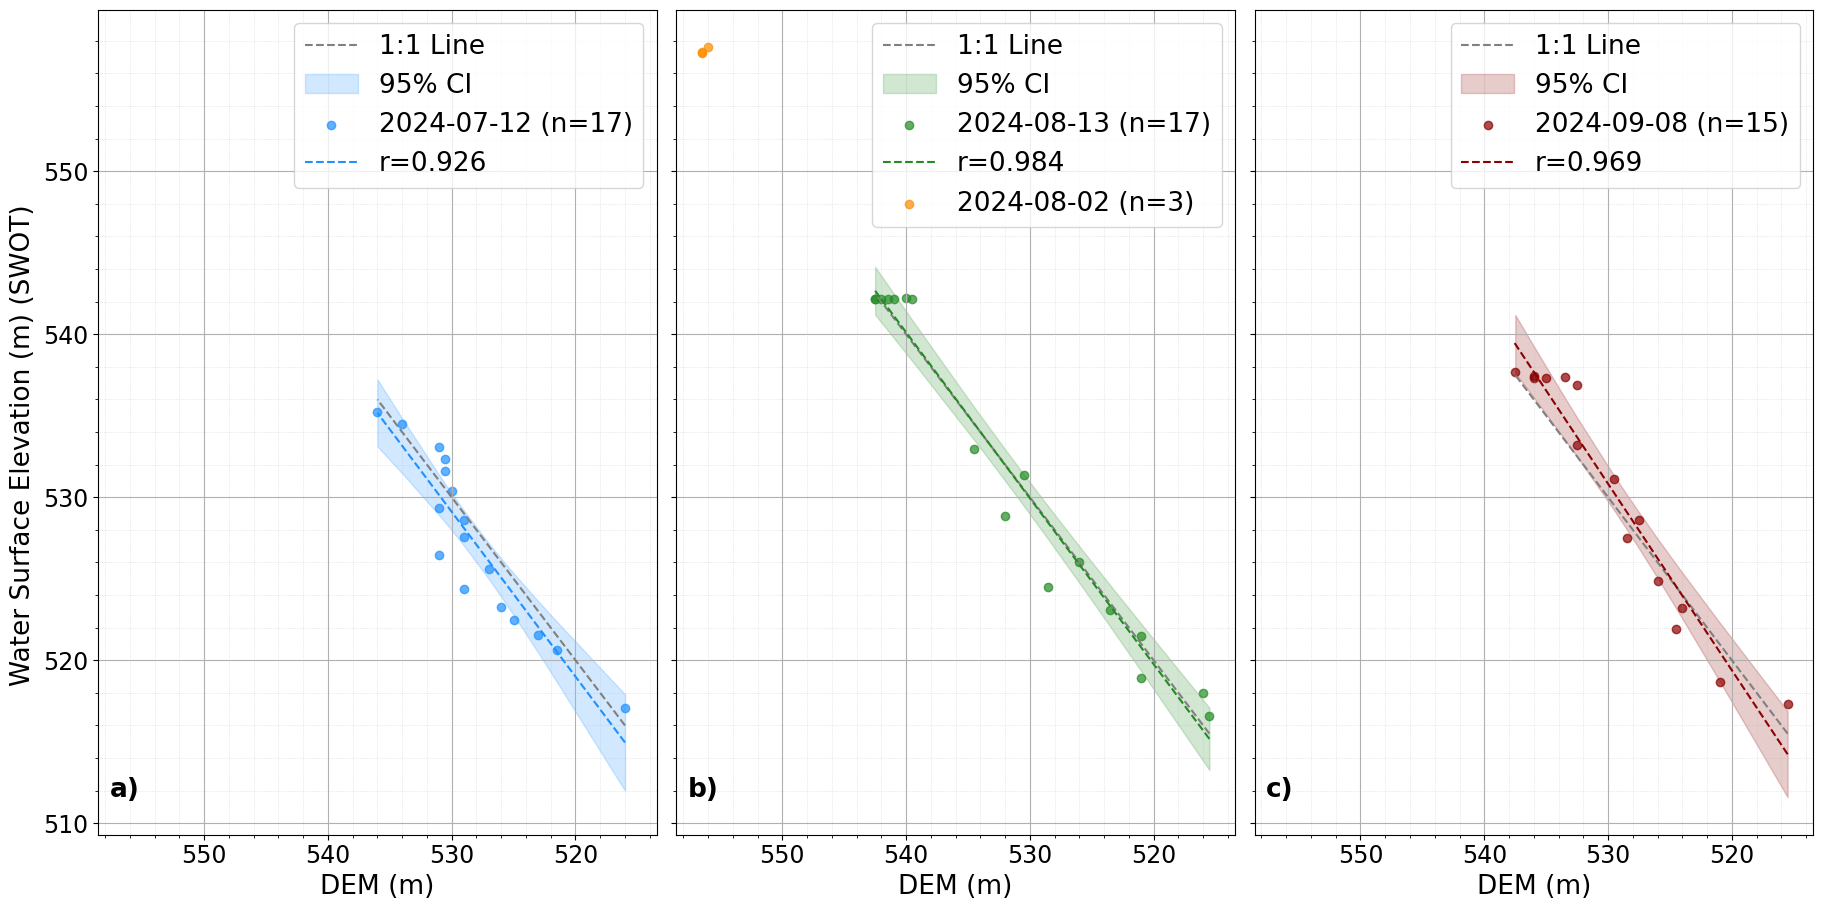

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import t

# Load the DEM_nodes_val_3dates data
#df_validation = pd.read_excel("/content/DEM_WSE_validation.xlsx")
df_validation = df_validation.dropna(subset=["DEM_mean", "WSE_nodes"])
df_validation["Date"] = pd.to_datetime(df_validation["Date"])

# Define font size
font_size = 19

# Define the colors for each date
colors = {
    "2024-07-12": "dodgerblue",
    "2024-08-02": "darkorange",
    "2024-08-13": "forestgreen",
    "2024-09-08": "darkred",
}

# Get unique dates from the DataFrame, excluding 2024-08-02 for separate plotting
unique_dates_to_plot = df_validation["Date"].dt.strftime("%Y-%m-%d").unique().tolist()
if "2024-08-02" in unique_dates_to_plot:
    unique_dates_to_plot.remove("2024-08-02")

# Prepare subplots
fig, axs = plt.subplots(1, len(unique_dates_to_plot), figsize=(len(unique_dates_to_plot) * 6, 10), sharex=True, sharey=True)

# Flatten axs for easy iteration if there's more than one subplot
if len(unique_dates_to_plot) > 1:
    axs = axs.flatten()
else:
    axs = [axs] # Make it a list so the loop works

# Plot each panel
for i, date_str in enumerate(unique_dates_to_plot):
    ax = axs[i]

    # Filter data for the current date
    data = df_validation[df_validation["Date"].dt.strftime("%Y-%m-%d") == date_str].copy()

    if not data.empty:
        # Extract 1D numpy arrays
        X = data["DEM_mean"].to_numpy(dtype=float)
        y = data["WSE_nodes"].to_numpy(dtype=float)
        xlabel = "DEM (m)"
        n = len(y)

        # Skip if not enough data points to fit a regression
        if n < 2:
            ax.set_xlabel(xlabel, fontsize=font_size)
            ax.tick_params(axis='both', which='major', labelsize=font_size - 2)
            ax.grid(True)
            ax.yaxis.set_minor_locator(AutoMinorLocator(5))
            ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator(5))
            ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.invert_xaxis()
            continue

        # Pearson correlation
        try:
            pearson_corr = float(np.corrcoef(X, y)[0, 1])
        except Exception:
            pearson_corr = np.nan

        # Compute limits for the 1:1 line using both X and y
        min_val = np.nanmin([np.nanmin(X), np.nanmin(y)])
        max_val = np.nanmax([np.nanmax(X), np.nanmax(y)])

        # Plot the 1:1 line
        ax.plot([min_val, max_val], [min_val, max_val],
                color='gray', linestyle='--', label='1:1 Line')

        # Linear regression
        X_2d = X.reshape(-1, 1)
        model = LinearRegression().fit(X_2d, y)
        y_pred = model.predict(X_2d)

        # 95% confidence interval for the mean prediction at each observed X
        p = 2  # intercept and slope
        can_ci = n > p
        if can_ci:
            residuals = y - y_pred
            ser = np.sqrt(np.sum(residuals**2) / (n - p))  # Standard error of residuals

            x_mean = X.mean()
            denom = np.sum((X - x_mean)**2)

            # Handle zero variance in X to avoid division by zero
            if denom <= 0:
                se_pred = ser * np.sqrt(1.0 / n) * np.ones_like(X, dtype=float)
            else:
                se_pred = ser * np.sqrt(1.0 / n + (X - x_mean)**2 / denom)

            alpha = 0.05  # 95% CI
            degrees_freedom = n - p
            t_critical = t.ppf(1 - alpha / 2, degrees_freedom)

            margin_of_error = t_critical * se_pred
            lower_bound = y_pred - margin_of_error
            upper_bound = y_pred + margin_of_error

            # Sort by X for a clean fill_between
            sorted_idx = np.argsort(X)
            x_sorted = X[sorted_idx]
            lower_sorted = lower_bound[sorted_idx]
            upper_sorted = upper_bound[sorted_idx]

            ax.fill_between(x_sorted, lower_sorted, upper_sorted,
                            color=colors.get(date_str, 'gray'), alpha=0.2, label="95% CI")

        # Scatter points
        ax.scatter(X, y, color=colors.get(date_str, 'gray'), label=f"{date_str} (n={n})", alpha=0.7)

        # Regression line and R-value (only for dates being plotted as main panels)
        slope = float(model.coef_[0])
        intercept = float(model.intercept_)
        x_line = np.array([min_val, max_val])
        y_line = intercept + slope * x_line
        ax.plot(x_line, y_line, color=colors.get(date_str, 'gray'), linestyle='--',
                label=f"r={pearson_corr:.3f}" if np.isfinite(pearson_corr) else "r=NA")


        # Axes formatting
        ax.set_xlabel(xlabel, fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size - 2)
        ax.grid(True)  # Main grid

        # Minor grids
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.5)

        # Invert X axis as in the original code
        ax.invert_xaxis()

        # Overlay August 2 data on the August 13 panel if available
        if date_str == "2024-08-13":
             data_0802 = df_validation[df_validation["Date"].dt.strftime("%Y-%m-%d") == "2024-08-02"].copy()
             if not data_0802.empty:
                ax.scatter(data_0802["DEM_mean"], data_0802["WSE_nodes"],
                       color=colors.get("2024-08-02", "tab:orange"),
                       label="2024-08-02 (n={})".format(len(data_0802)), alpha=0.7)


        ax.legend(fontsize=font_size, loc='upper right')

# Global Y-axis label
fig.text(-0.01, 0.5, "Water Surface Elevation (m) (SWOT)",
         va='center', rotation='vertical', fontsize=font_size)

# Add panel labels
panel_labels = [f"{chr(97 + i)})" for i in range(len(unique_dates_to_plot))]  # a), b), c)...
for i in range(len(unique_dates_to_plot)):
    axs[i].text(0.02, 0.07, panel_labels[i],
                transform=axs[i].transAxes, ha='left', va='top',
                fontsize=font_size, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()